In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

from PIL import Image
import matplotlib.pyplot as plt
import time
import os

plt.ion()
multiGPU = False

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip test

In [0]:
!unzip train

In [0]:
train_image_path = "/content/train"
test_image_path = "/content/test"
labels_csv_path = "/content/labels.csv"
sample_sub_path = "/content/sample_submission.csv"

In [0]:
class Dog(Dataset):
    """Dog breed identification dataset."""

    def __init__(self, image_dir, dataframe, transform=None):

        #img_dir (string): Directory with all the images.        
        #dataframe: Pandas dataframe obtained by read_csv().
        #transform (callable, optional): Optional transform to be applied on a sample.

        self.labels_frame = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, index):
        image_name = os.path.join(self.image_dir, self.labels_frame.id[index]) + ".jpg"
        image = Image.open(image_name)
        label = self.labels_frame.target[index]

        if self.transform:image = self.transform(image)

        return [image, label]

cairn
Shape of the image is:  (500, 375)


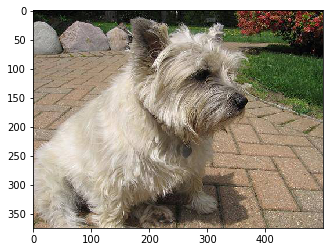

In [9]:
data_frame = pd.read_csv(labels_csv_path)
labelnames = pd.read_csv(sample_sub_path).keys()[1:]
codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
data_frame['target'] =  [breed_to_code[x] for x in data_frame.breed]

#splitting training data into train, test

cut = int(len(data_frame)*0.8)
train, test = np.split(data_frame, [cut], axis=0)
test = test.reset_index(drop=True)

train_ds = Dog(train_image_path, train)
test_ds = Dog(train_image_path, test)
index = 29
plt.imshow(train_ds[index][0])
print(code_to_breed[train_ds[index][1]])
print("Shape of the image is: ", train_ds[index][0].size)

In [10]:
#Reshaping the image. Defining data_transfrom

data_transform = transforms.Compose([
                                     transforms.RandomSizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:704: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


In [11]:
#Applying data_transform to both datasets, and checking new size of images

train_ds = Dog(train_image_path, train, data_transform)
test_ds = Dog(train_image_path, test, data_transform)

datasets = {"train": train_ds, "val": test_ds}

index = 29
print(code_to_breed[train_ds[index][1]])
print("Shape of the image is: ", train_ds[index][0].shape)

cairn
Shape of the image is:  torch.Size([3, 224, 224])


In [0]:
trainloader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)
testloader = DataLoader(test_ds, batch_size=8, shuffle=True, num_workers=4)

dataloaders = {"train": trainloader, "val": testloader}

In [0]:
#Define variables if gpu to be used

if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
    use_gpu = False
FloatTensor = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_gpu else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_gpu else torch.ByteTensor
Tensor = FloatTensor

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = model.state_dict()
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      since_epoch = time.time()
      if phase == 'train':
        scheduler.step()
        model.train(True)  # Set model to training mode
      else:
        model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    for data in dataloaders[phase]:
      inputs, labels = data

      inputs = Variable(inputs.type(Tensor))
      labels = Variable(labels.type(LongTensor))

      optimizer.zero_grad()

      #forward
      outputs = model(inputs)
      _, preds = torch.max(outputs.data, 1)
      loss = criterion(outputs, labels)

      # backward + optimize only if in training phase
      if phase == 'train':
        loss.backward()
        optimizer.step()

      running_loss += loss.data
      running_corrects += torch.sum(preds == labels.data) 

    epoch_loss = running_loss/len(datasets[phase])
    epoch_acc = running_corrects/len(datasets[phase])

    time_elapsed_epoch = time.time() - since_epoch

    print('{} Loss: {:.4f} Acc: {:.4f} in {:.0f}m {:.0f}s'.format(
                phase, epoch_loss, epoch_acc, time_elapsed_epoch // 60, time_elapsed_epoch % 60))

    if phase == 'val' and epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = model.state_dict()

  print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  print(best_model_wts)
  return model 

In [15]:
#Loading the model

model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 120)

if torch.cuda.device_count() > 1 and multiGPU:
  print("Using", torch.cuda.device_count(), "GPUs")
  model_ft = nn.DataParallel(model_ft)

if use_gpu: model_ft.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:02<00:00, 84.7MB/s]


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

In [0]:
submission = pd.read_csv(sample_sub_path)
output = pd.DataFrame(index=submission.index, columns=submission.keys() )
output['id'] = submission['id']
submission['target'] =  [0] * len(submission)

data_transform = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

submission_ds = Dog(test_image_path, submission, data_transform)

sub_loader = DataLoader(submission_ds, batch_size=8,
                        shuffle=False, num_workers=4)


def test_sumission(model):
    since = time.time()
    sub_outputs = []
    model.train(False)  # Set model to evaluate mode
    # Iterate over data.
    for data in sub_loader:
        # get the inputs
        inputs, labels = data

        inputs = Variable(inputs.type(Tensor))
        labels = Variable(labels.type(LongTensor))

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        sub_outputs.append(outputs.data.cpu().numpy())

    sub_outputs = np.concatenate(sub_outputs)
    for idx,row in enumerate(sub_outputs.astype(float)):
        sub_outputs[idx] = np.exp(row)/np.sum(np.exp(row))

    output.loc[:,1:] = sub_outputs
        
    print()
    time_elapsed = time.time() - since
    print('Run complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return output

In [0]:
odf = test_sumission(model_ft)
odf.to_csv("dogs_id.csv", index=False)